# Kaggle Housing Prices Prediction Notebook

## Import Libraries and Load Data

In [641]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from scipy import stats

from sklearn.feature_selection import mutual_info_regression
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

In [642]:
train = pd.read_csv('train.csv')
train = train.drop('Id', axis=1)

test = pd.read_csv('test.csv')
test = test.drop('Id', axis=1)

In [643]:
train.shape

(1460, 80)

In [644]:
test.shape

(1459, 79)

In [645]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

## Data Preprocessing

### Handle Missing Values

In [646]:
# drop columns if they are missing more than 50% of values
def drop_useless_columns(df):
    dropped_cols = []
    for i in df.columns:
        if df[i].isna().sum() > len(df)/2:
            df = df.drop(columns=[i])
            dropped_cols.append(i)
    return dropped_cols
        
cols_to_drop = drop_useless_columns(train)
train = train.drop(columns=cols_to_drop)
test = test.drop(columns=cols_to_drop)
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [647]:
cols_to_drop

['Alley', 'PoolQC', 'Fence', 'MiscFeature']

#### Impute missing values

In [648]:
train.isna().sum()[lambda x: x>0].sort_values(ascending=False)

FireplaceQu     690
LotFrontage     259
GarageType       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81
GarageCond       81
BsmtExposure     38
BsmtFinType2     38
BsmtQual         37
BsmtCond         37
BsmtFinType1     37
MasVnrType        8
MasVnrArea        8
Electrical        1
dtype: int64

In [649]:
def impute(df):
    
    for col in ('GarageYrBlt','GarageArea','GarageCars','MasVnrArea'):
        df[col] = df[col].fillna(0)
        
    levels = ['NA','Po','Fa','TA','Gd','Ex']
    
    categories = {
        'GarageFinish':['NA','Unf','RFn','Fin'],
        'GarageCond': levels,
        'GarageQual': levels,
        'GarageType':['NA','Detchd','CarPort','BuiltIn','Basment','Attchd','2Types'],
        'BsmtCond': levels,
        'BsmtExposure': ['NA','No','Mn','Av','Gd'],
        'BsmtQual': levels,
        'BsmtFinType1':['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],
        'BsmtFinType2': ['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],
        'FireplaceQu': levels
    }
    
    for col in ('GarageFinish','GarageCond','GarageQual','GarageType','BsmtCond','BsmtExposure','BsmtQual',
               'BsmtFinType1', 'BsmtFinType2','FireplaceQu'):
        cat_type = pd.api.types.CategoricalDtype(categories=categories[col])
        df[col] = df[col].astype(cat_type)
        df[col] = df[col].fillna('NA')

    df['MasVnrType'] = df['MasVnrType'].fillna('None')
    df['MSZoning'] = df.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    
    for var in df.select_dtypes(include = ['float64', 'int64']):
        if var != 'SalePrice':
            if df[var].dtype == 'int64':
                df[var] = df[var].fillna(df[var].median())
            else:
                # Impute with mean for float columns
                df[var] = df[var].fillna(np.mean(df[var]))

    for var in df.select_dtypes(include = ['O']):
        df[var] = df[var].astype('category')
        df[var] = df[var].fillna(df[var].mode()[0])
    return df

train = impute(train)
test = impute(test)

In [650]:
train.isna().sum()[lambda x: x>0]

Series([], dtype: int64)

### Baseline dataset scoring - RMSE

In [651]:
categorical_features = list(train.select_dtypes(include=["category"]).columns)
categorical_features

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [652]:
# adopted from https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices
from sklearn.metrics import mean_squared_error

def score_dataset(X, y, model=XGBRegressor()):
    
    if X.select_dtypes(include=["category"]).empty:
        X_copy = X.copy()  # Avoid unnecessary copy if no categorical features
    else:
        X_copy = X.copy()
        for colname in X.select_dtypes(["category"]):
            X_copy.loc[:, colname] = X_copy[colname].cat.codes  # Label encoding

    # Apply logarithmic transformation for RMSLE
    log_y = np.log1p(y)  # Use log1p for non-negative values

    # Cross-validation with RMSLE scoring
    rmse = np.sqrt(mean_squared_error(y_true=np.expm1(log_y), y_pred=model.predict(X_copy)))  # Efficient RMSLE calculation

    return rmse

In [653]:
X = train.drop(columns=['SalePrice'])
y = train['SalePrice']

model=XGBRegressor(enable_categorical=True)
model.fit(X,y)

score_dataset(X,y,model)

/var/folders/sw/6pmb_by53cx1hvn3p_xkx44m0000gn/T/ipykernel_1775/3376072102.py:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_copy.loc[:, colname] = X_copy[colname].cat.codes  # Label encoding


1189.4769241754677

### Normalizing Sale Price Distribution

/var/folders/sw/6pmb_by53cx1hvn3p_xkx44m0000gn/T/ipykernel_1775/2984525733.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, kde=False, fit=stats.norm, ax=ax1)


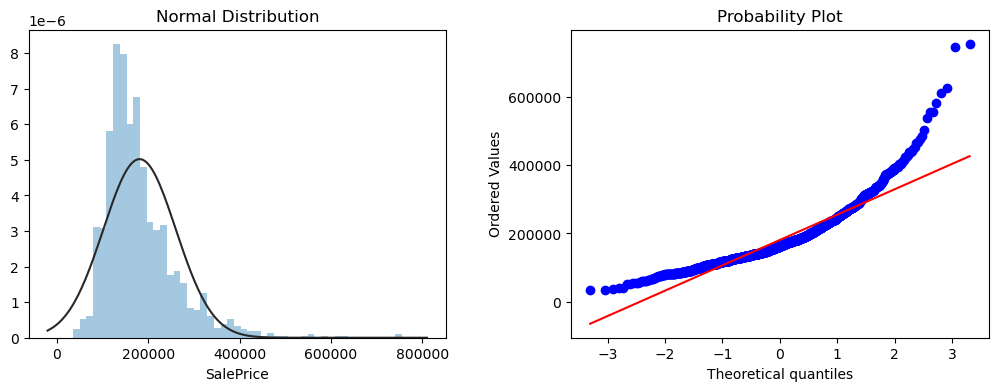

In [654]:
y = train['SalePrice']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.set_title('Normal Distribution')
sns.distplot(y, kde=False, fit=stats.norm, ax=ax1)

ax2.set_title('Normal Probability Plot')
stats.probplot(y, plot=ax2)  

plt.subplots_adjust(left=0.1, right=0.9, wspace=0.3)

plt.show()

/var/folders/sw/6pmb_by53cx1hvn3p_xkx44m0000gn/T/ipykernel_1775/3398227558.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, kde=False, fit=stats.lognorm, ax=ax1)


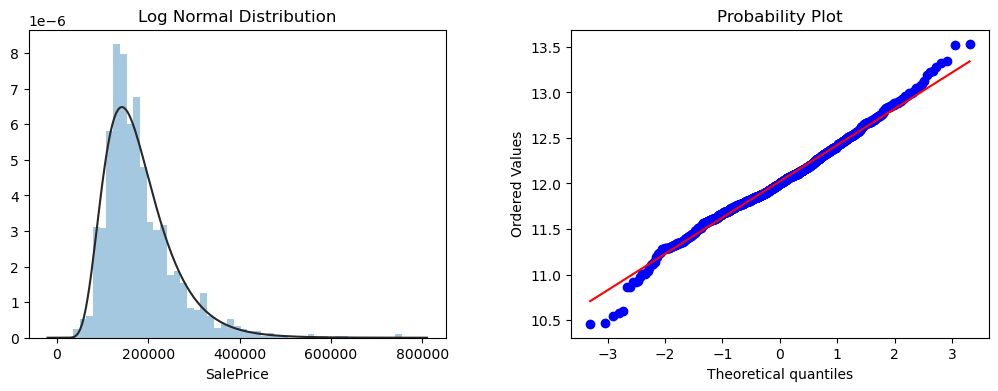

In [655]:
log_y = np.log1p(y)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.set_title('Log Normal Distribution')
sns.distplot(y, kde=False, fit=stats.lognorm, ax=ax1)

ax2.set_title('Normal Probability Plot')
stats.probplot(log_y, plot=ax2)  

plt.subplots_adjust(left=0.1, right=0.9, wspace=0.3)

plt.show()

In [656]:
train['log_y'] = np.log1p(train['SalePrice'])
train[['log_y']].head()

,log_y
0,12.247699
1,12.109016
2,12.317171
3,11.849405
4,12.429220


### Target Encoding

Implement a practice called mean encoding, which encodes the mean of the target variable binned by each categorical feature.

In [657]:
# categorical_features = train.select_dtypes(include = ['object']).columns.to_list()
# train[categorical_features] = train[categorical_features].astype('category')

selected_features = categorical_features + ['log_y']

selected_features

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition',
 'log_y']

In [658]:
def encode_dict(df, column):
    column_encoded = column + '_encoded'
    
    column_unique = df[column].unique().to_list()
    column_encoded_unique = list(df[column_encoded].unique())
    
    encoded_dict = dict(zip(column_unique, column_encoded_unique))
    
    return encoded_dict

In [659]:
def encode_categoricals(df):
    
    column_dict = {}
    
    for i in categorical_features: 
        df[i + '_encoded'] = df.groupby(i)["log_y"].transform("mean")
        
        means_dict = encode_dict(df, i)
        
        column_dict[i + '_encoded'] = means_dict
        
    return df, column_dict

train, encodings = encode_categoricals(train)[0], encode_categoricals(train)[1]
train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,KitchenQual_encoded,Functional_encoded,FireplaceQu_encoded,GarageType_encoded,GarageFinish_encoded,GarageQual_encoded,GarageCond_encoded,PavedDrive_encoded,SaleType_encoded,SaleCondition_encoded
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,12.222342,12.038518,11.808915,12.160783,12.172678,12.068546,12.070489,12.059901,11.991068,12.005040
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,11.810600,12.038518,12.186421,12.160783,12.172678,12.068546,12.070489,12.059901,11.991068,12.005040
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,12.222342,12.038518,12.186421,12.160783,12.172678,12.068546,12.070489,12.059901,11.991068,12.005040
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,12.222342,12.038518,12.256538,11.765651,11.818982,12.068546,12.070489,12.059901,11.991068,11.788783
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,12.222342,12.038518,12.186421,12.160783,12.172678,12.068546,12.070489,12.059901,11.991068,12.005040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,11.810600,12.038518,12.186421,12.160783,12.172678,12.068546,12.070489,12.059901,11.991068,12.005040
1456,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,11.810600,11.862174,12.186421,12.160783,11.818982,12.068546,12.070489,12.059901,11.991068,12.005040
1457,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,12.222342,12.038518,12.256538,12.160783,12.172678,12.068546,12.070489,12.059901,11.991068,12.005040
1458,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,12.222342,12.038518,11.808915,12.160783,11.818982,12.068546,12.070489,12.059901,11.991068,12.005040


In [660]:
encodings

{'MSZoning_encoded': {'RL': 12.085891075733121,
  'RM': 11.692901373997314,
  'C (all)': 11.118275488302467,
  'FV': 12.246620743654088,
  'RH': 11.749847853755815},
 'Street_encoded': {'Pave': 12.025528976337668, 'Grvl': 11.66744416431723},
 'LotShape_encoded': {'Reg': 11.936100574945565,
  'IR1': 12.163470952268302,
  'IR2': 12.318454555801209,
  'IR3': 12.205418707051646},
 'LandContour_encoded': {'Lvl': 12.02270045128515,
  'Bnk': 11.810747521392866,
  'Low': 12.120092297979099,
  'HLS': 12.259261767420849},
 'Utilities_encoded': {'AllPub': 12.024189451756053,
  'NoSeWa': 11.83138646878959},
 'LotConfig_encoded': {'Inside': 12.001906276364101,
  'FR2': 12.03474765557997,
  'Corner': 12.027452046465157,
  'CulDSac': 12.249814995893566,
  'FR3': 12.195689049811596},
 'LandSlope_encoded': {'Gtl': 12.020571428126665,
  'Mod': 12.076872526715583,
  'Sev': 12.130566821023475},
 'Neighborhood_encoded': {'CollgCr': 12.163646694410446,
  'Veenker': 12.34418038510064,
  'Crawfor': 12.2066641

In [661]:
def encode_test(df):
    # create new _encode columns
    # assign value based on dictionary
    for i in categorical_features: 
        find_dict = encodings[i + '_encoded']
        df[i + '_encoded'] = df[i].replace(find_dict)
    return df

test = encode_test(test)
test.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       ...
       'KitchenQual_encoded', 'Functional_encoded', 'FireplaceQu_encoded',
       'GarageType_encoded', 'GarageFinish_encoded', 'GarageQual_encoded',
       'GarageCond_encoded', 'PavedDrive_encoded', 'SaleType_encoded',
       'SaleCondition_encoded'],
      dtype='object', length=114)

### Score check

In [662]:
X = train.drop(columns=['SalePrice'])
y = train['SalePrice']

model=XGBRegressor(enable_categorical=True)
model.fit(X,y)

score_dataset(X,y,model)

/var/folders/sw/6pmb_by53cx1hvn3p_xkx44m0000gn/T/ipykernel_1775/3376072102.py:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_copy.loc[:, colname] = X_copy[colname].cat.codes  # Label encoding


97.95992543354481

### Mutual Information Scoring

In [663]:
# adopted from https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices

def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.figure(figsize=(12,12))
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [664]:
# calculate the mi_scores for the training data. Since the test data doesn't have the target var, we can't 
# calc mi_scores for that data

mi_scores = make_mi_scores(X, y)
mi_scores

log_y                   5.451099
OverallQual             0.577949
Neighborhood            0.525427
Neighborhood_encoded    0.507968
GarageArea              0.498899
                          ...   
MoSold                  0.000000
Functional_encoded      0.000000
RoofMatl_encoded        0.000000
BsmtFinSF2              0.000000
Utilities_encoded       0.000000
Name: MI Scores, Length: 115, dtype: float64

In [665]:
# drop columns where mi_score = 0
drop_columns = mi_scores[lambda x: x==0].index.to_list()
train = train.drop(columns=drop_columns)
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,Electrical_encoded,KitchenQual_encoded,FireplaceQu_encoded,GarageType_encoded,GarageFinish_encoded,GarageQual_encoded,GarageCond_encoded,PavedDrive_encoded,SaleType_encoded,SaleCondition_encoded
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,12.061446,12.222342,11.808915,12.160783,12.172678,12.068546,12.070489,12.059901,11.991068,12.005040
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,12.061446,11.810600,12.186421,12.160783,12.172678,12.068546,12.070489,12.059901,11.991068,12.005040
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,12.061446,12.222342,12.186421,12.160783,12.172678,12.068546,12.070489,12.059901,11.991068,12.005040
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,12.061446,12.222342,12.256538,11.765651,11.818982,12.068546,12.070489,12.059901,11.991068,11.788783
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,12.061446,12.222342,12.186421,12.160783,12.172678,12.068546,12.070489,12.059901,11.991068,12.005040


In [666]:
drop_columns

['MoSold',
 'Functional_encoded',
 'RoofMatl_encoded',
 'BsmtFinSF2',
 'Utilities_encoded']

## EDA

In [667]:
# split data into quantitative and qualitative so it's easier to work with
quantitative = [f for f in train.columns if train.dtypes[f] != 'category' and '_encoded' not in f]
quantitative.remove('SalePrice')
qualitative = [f for f in train.columns if train.dtypes[f] == 'category']
qualitative_encoded = [f for f in train.columns if train.dtypes[f] != 'category' and '_encoded' in f]

### Numeric Variable Exploration

In [668]:
numeric_data = train[quantitative]
numeric_data

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,log_y
0,60,65.0,8450,7,5,2003,2003,196.0,706,150,...,548,0,61,0,0,0,0,0,2008,12.247699
1,20,80.0,9600,6,8,1976,1976,0.0,978,284,...,460,298,0,0,0,0,0,0,2007,12.109016
2,60,68.0,11250,7,5,2001,2002,162.0,486,434,...,608,0,42,0,0,0,0,0,2008,12.317171
3,70,60.0,9550,7,5,1915,1970,0.0,216,540,...,642,0,35,272,0,0,0,0,2006,11.849405
4,60,84.0,14260,8,5,2000,2000,350.0,655,490,...,836,192,84,0,0,0,0,0,2008,12.429220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,1999,2000,0.0,0,953,...,460,0,40,0,0,0,0,0,2007,12.072547
1456,20,85.0,13175,6,6,1978,1988,119.0,790,589,...,500,349,0,0,0,0,0,0,2010,12.254868
1457,70,66.0,9042,7,9,1941,2006,0.0,275,877,...,252,0,60,0,0,0,0,2500,2010,12.493133
1458,20,68.0,9717,5,6,1950,1996,0.0,49,0,...,240,366,0,112,0,0,0,0,2010,11.864469


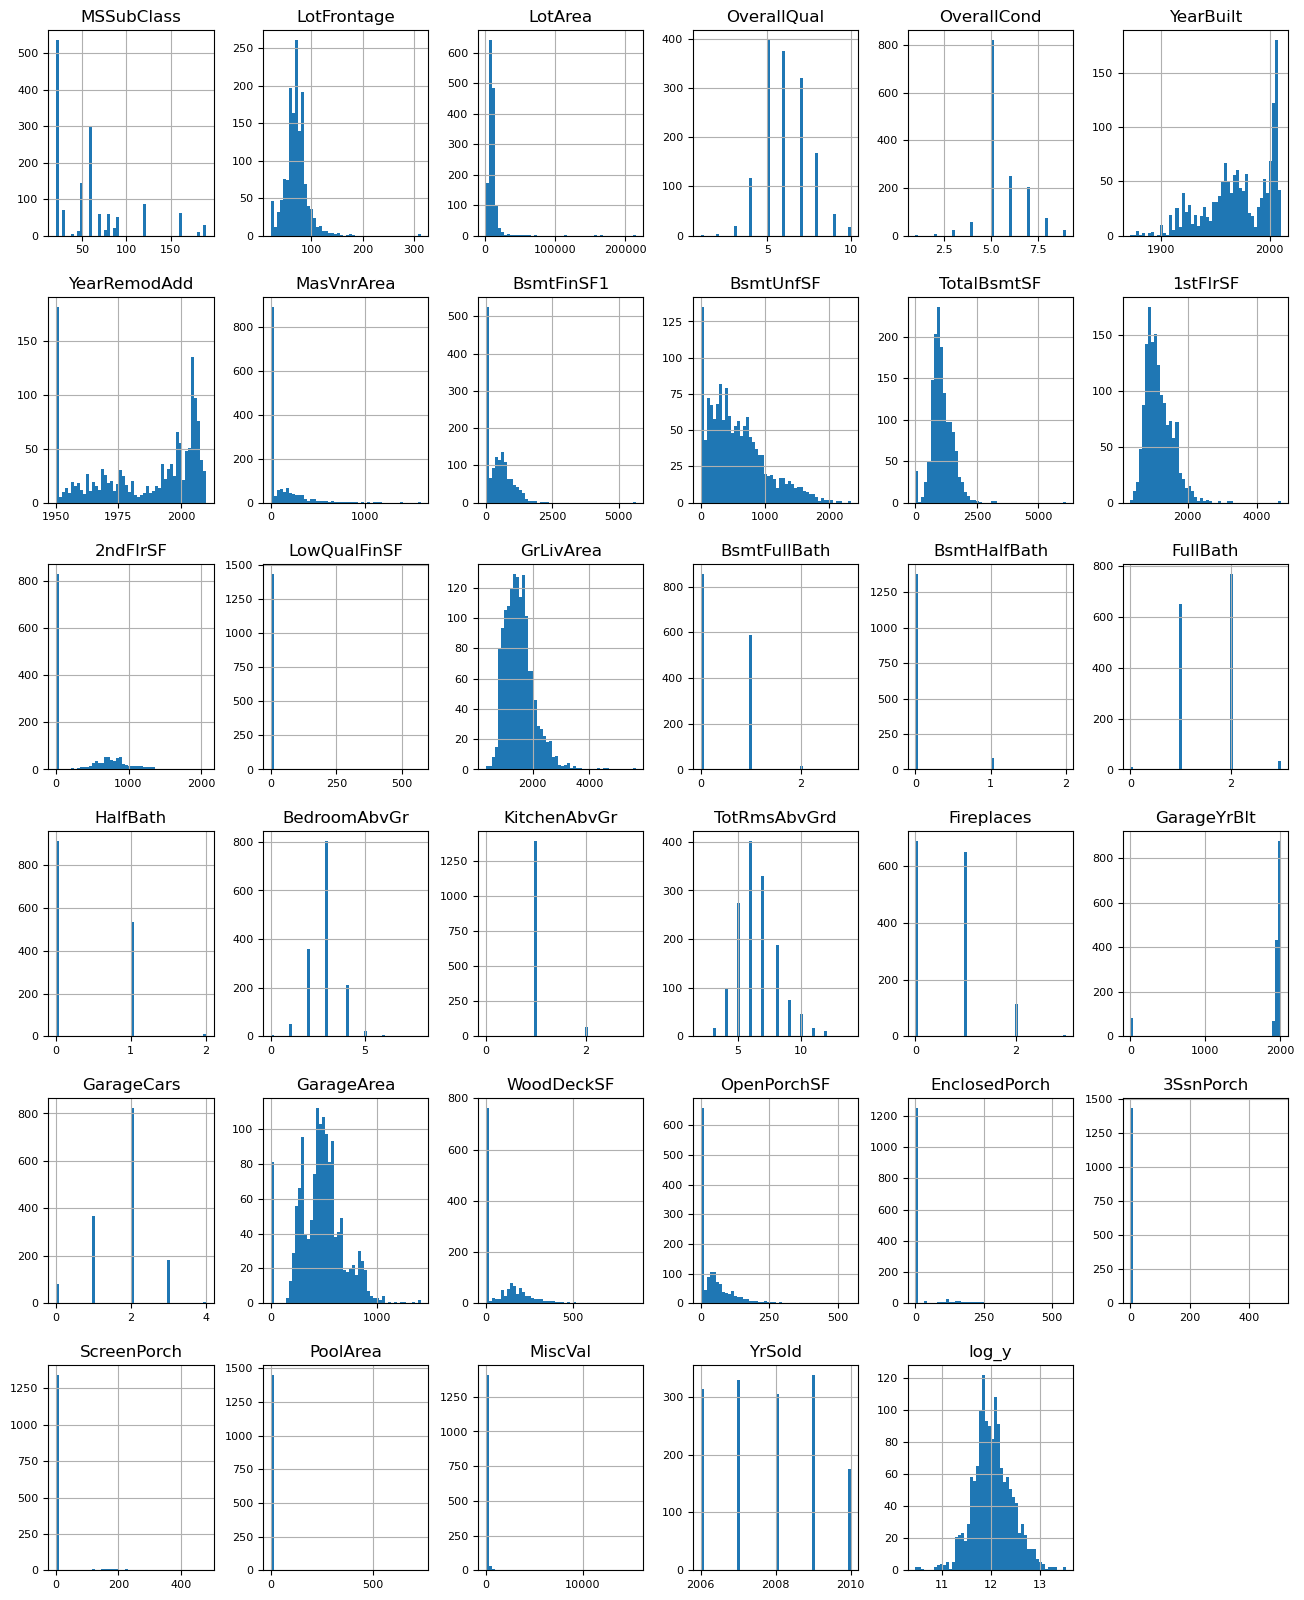

In [669]:
numeric_data.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

### Feature Engineering

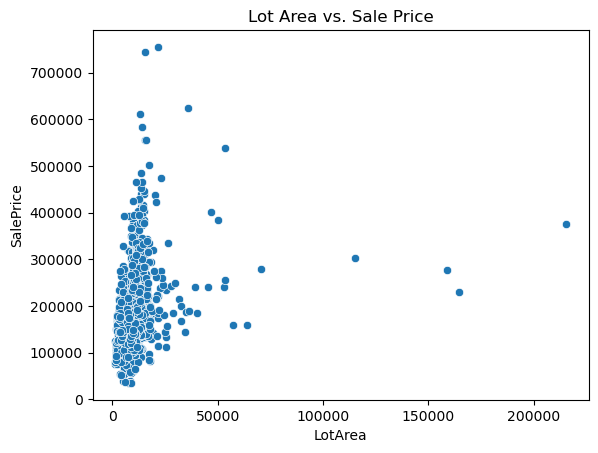

In [670]:
sns.scatterplot(x='LotArea', y='SalePrice', data=train)
plt.title('Lot Area vs. Sale Price')
plt.show()

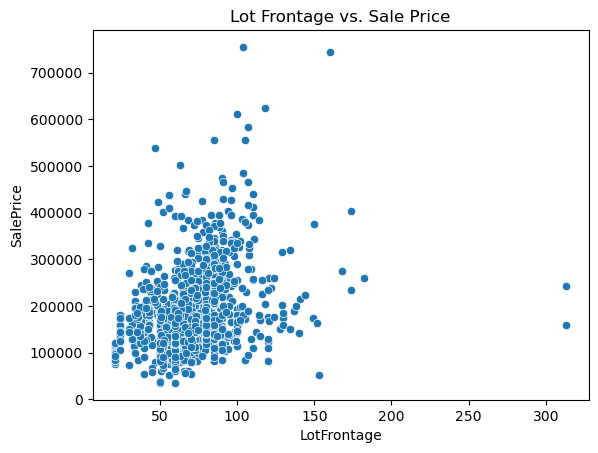

In [671]:
sns.scatterplot(x='LotFrontage', y='SalePrice', data=train)
plt.title('Lot Frontage vs. Sale Price')
plt.show()

### Score Check

In [672]:
X = train.drop(columns=['SalePrice'])
y = train['SalePrice']

model=XGBRegressor(enable_categorical=True)
model.fit(X,y)

score_dataset(X,y,model)

/var/folders/sw/6pmb_by53cx1hvn3p_xkx44m0000gn/T/ipykernel_1775/3376072102.py:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_copy.loc[:, colname] = X_copy[colname].cat.codes  # Label encoding


105.98144416610027

### Categorical Variable Exploration

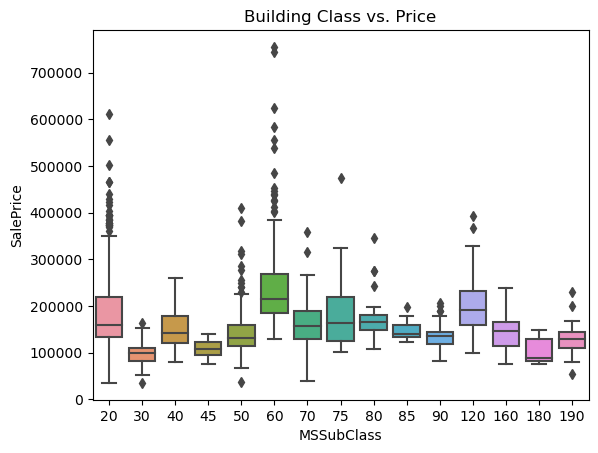

In [673]:
"""Visualizing building class by price"""
sns.boxplot(x='MSSubClass', y='SalePrice', data=train)
plt.title('Building Class vs. Price')
plt.show()

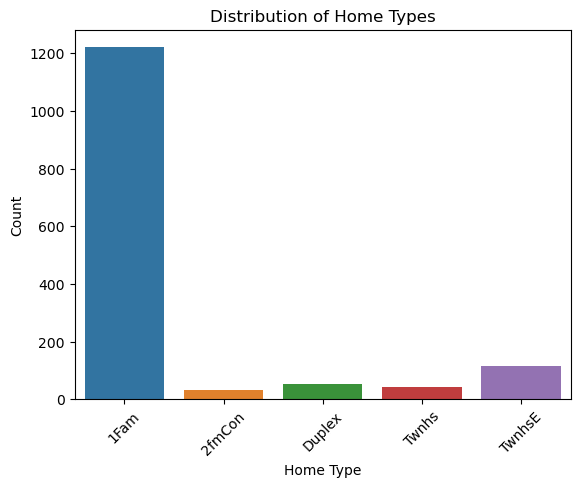

In [674]:
""" Visualize the distribution of building types """
sns.countplot(data=train, x='BldgType')
plt.title('Distribution of Home Types')
plt.xlabel('Home Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

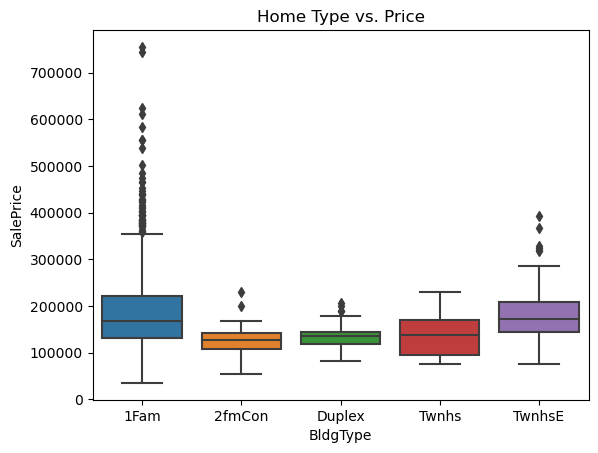

In [675]:
"""Visualizing home type by price"""
sns.boxplot(x='BldgType', y='SalePrice', data=train)
plt.title('Home Type vs. Price')
plt.show()

In [676]:
# split data into quantitative and qualitative so it's easier to work with
quantitative = [f for f in train.columns if train.dtypes[f] != 'category' and '_encoded' not in f]
quantitative.remove('SalePrice')
qualitative = [f for f in train.columns if train.dtypes[f] == 'category']
qualitative_encoded = [f for f in train.columns if train.dtypes[f] != 'category' and '_encoded' in f]

<Axes: >

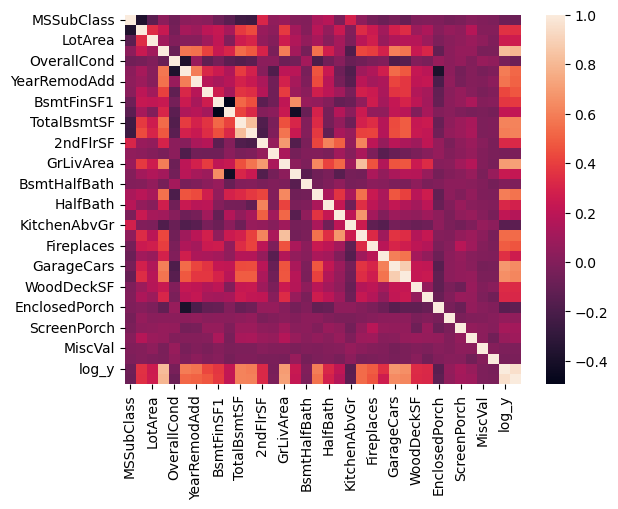

In [677]:
quant_corr = train[quantitative + ['SalePrice']].corr()
sns.heatmap(quant_corr)

<Axes: >

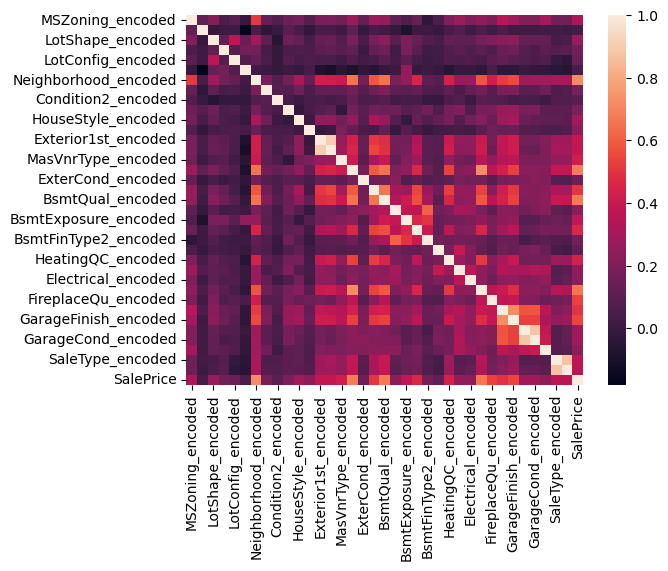

In [678]:
qual_corr = train[qualitative_encoded + ['SalePrice']].corr()
sns.heatmap(qual_corr)

## PCA

In [679]:
def implement_pca(data, feature_names=None):
    
    # first step is to standardize the data
    data_standardized = (data - data.mean(axis=0)) / data.std(axis=0)
    
    # apply PCA
    pca = PCA()
    data_pca = pca.fit_transform(data)
    
    # adopted from https://www.kaggle.com/code/ryanholbrook/principal-component-analysis
    component_names = [f"PC{i+1}" for i in range(data_pca.shape[1])]
    data_pca = pd.DataFrame(data_pca, columns=component_names)
    
    # return number of principle components
    n = pca.n_components_
    
    # return explained variance ratio for each feature
    explained_variance_ratio = pca.explained_variance_ratio_
    
    # return names of features to be maintained
    if feature_names is not None:
        pca_features = feature_names
    else:
        pca_features = list(data.columns)

    return n, data_pca, pca_features, explained_variance_ratio

numeric_datset = train.select_dtypes(include = ['float64', 'int64']).drop(columns=['SalePrice'])

pca_results = implement_pca(numeric_datset)
pca_results

(71,
               PC1         PC2          PC3         PC4          PC5  \
 0    -2065.002969   51.642495  -273.519088  748.958024  -166.420139   
 1     -911.594568   21.656322   750.566475  227.805074   -46.831448   
 2      734.683423  112.715116  -463.427991  426.160112  -127.424488   
 3     -970.321159  -26.505560  -570.458406  199.959734   -99.197970   
 4     3758.484722  651.818960  -539.327771  540.693724  -134.979740   
 ...           ...         ...          ...         ...          ...   
 1455 -2604.588037   63.757538  -641.450349 -266.840156   -21.606242   
 1456  2684.909035  942.952372   549.044366  -99.916220    24.551164   
 1457 -1457.774744  632.026048 -1016.324700  521.202787  2402.002079   
 1458  -811.369375 -590.092608   291.881827    0.847410   -56.054906   
 1459  -576.128842  -81.797278   701.981124  265.694246   -59.351354   
 
              PC6         PC7         PC8         PC9        PC10  ...  \
 0     -99.348562 -174.618143   62.903187   12.082949 -

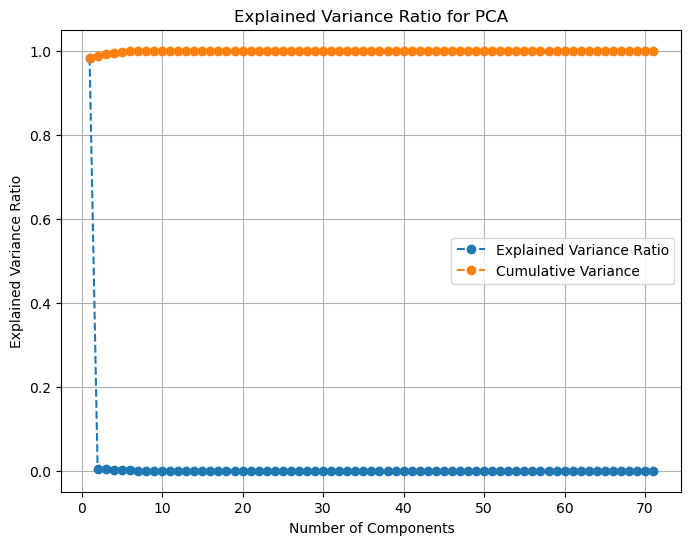

In [680]:
def plot_pca(data, explained_variance):
    
    num_components = len(explained_variance)

    plt.figure(figsize=(8, 6)) 

    plt.plot(range(1, num_components + 1), explained_variance, marker='o', linestyle='--', label='Explained Variance Ratio')
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance Ratio')

    plt.step(range(1, num_components + 1), explained_variance.cumsum(), marker='o', linestyle='--', label='Cumulative Variance')

    plt.title('Explained Variance Ratio for PCA')
    plt.grid(True)
    plt.legend()

    plt.show()
    
plot_pca(pca_results[1], pca_results[3])

**Look at mi scores of principal components to verify that they are high**

In [681]:
mi_scores = make_mi_scores(pca_results[1], train['SalePrice'])
indices_to_remove = [int(i[2:]) for i in mi_scores[lambda x: x==0].index.to_list()]
indices_to_remove

[41, 70]

In [682]:
columns_to_include = [element for element in pca_results[2] if element.index not in indices_to_remove]

Even though mi_scores aren't high for the bottom few features, we can assume that they still eliminate some variance within the data and therefore are still relevant.

#### Making final dataset based on PCA exploration

In [683]:
train = train[columns_to_include+['SalePrice']]
train

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,...,KitchenQual_encoded,FireplaceQu_encoded,GarageType_encoded,GarageFinish_encoded,GarageQual_encoded,GarageCond_encoded,PavedDrive_encoded,SaleType_encoded,SaleCondition_encoded,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,150,...,12.222342,11.808915,12.160783,12.172678,12.068546,12.070489,12.059901,11.991068,12.005040,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,284,...,11.810600,12.186421,12.160783,12.172678,12.068546,12.070489,12.059901,11.991068,12.005040,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,434,...,12.222342,12.186421,12.160783,12.172678,12.068546,12.070489,12.059901,11.991068,12.005040,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,540,...,12.222342,12.256538,11.765651,11.818982,12.068546,12.070489,12.059901,11.991068,11.788783,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,490,...,12.222342,12.186421,12.160783,12.172678,12.068546,12.070489,12.059901,11.991068,12.005040,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,1999,2000,0.0,0,953,...,11.810600,12.186421,12.160783,12.172678,12.068546,12.070489,12.059901,11.991068,12.005040,175000
1456,20,85.0,13175,6,6,1978,1988,119.0,790,589,...,11.810600,12.186421,12.160783,11.818982,12.068546,12.070489,12.059901,11.991068,12.005040,210000
1457,70,66.0,9042,7,9,1941,2006,0.0,275,877,...,12.222342,12.256538,12.160783,12.172678,12.068546,12.070489,12.059901,11.991068,12.005040,266500
1458,20,68.0,9717,5,6,1950,1996,0.0,49,0,...,12.222342,11.808915,12.160783,11.818982,12.068546,12.070489,12.059901,11.991068,12.005040,142125


In [684]:
X = train.drop(columns=['SalePrice'])
y = train['SalePrice']

model=XGBRegressor(enable_categorical=True)
model.fit(X,y)

score_dataset(X,y,model)

103.45273276550121

### Merge data for Model Building

We merge the training and test data so that we can modify both datasets at once. To differentiate between the two datasets, we will introduce a new column called 'ind', which labels the data as either 'test' or 'train'. After preprocessing the data, we will split the data back up again to train the model.

Note: the test dataset contains the same columns as the train dataset, with the exception of the target variable, 'SalePrice'.

In [685]:
train_columns = [i for i in train.columns]
train_columns = list(set(train_columns) - set(['log_y','SalePrice']))

test = test[train_columns]

In [686]:
merged_data = pd.concat([test.assign(ind="test"), train.assign(ind="train")], axis=0)
merged_data = merged_data.drop(columns=['SalePrice'])
merged_data.head()

,MiscVal,GarageType_encoded,LotConfig_encoded,GarageFinish_encoded,YearBuilt,2ndFlrSF,LandContour_encoded,KitchenAbvGr,BsmtHalfBath,Fireplaces,...,MasVnrArea,Exterior2nd_encoded,ScreenPorch,GarageArea,LandSlope_encoded,GarageQual_encoded,BsmtFinType1_encoded,OverallQual,ind,log_y
0,0,12.160783,12.001906,11.818982,1961,0,12.022700,1,0.0,0,...,0.0,12.209636,120,730.0,12.020571,12.068546,11.852854,5,test,NaN
1,12500,12.160783,12.027452,11.818982,1958,0,12.022700,1,0.0,0,...,108.0,11.838487,0,312.0,12.020571,12.068546,11.953320,6,test,NaN
2,0,12.160783,12.001906,12.320815,1997,701,12.022700,1,0.0,1,...,0.0,12.209636,0,482.0,12.020571,12.068546,12.301942,5,test,NaN
3,0,12.160783,12.001906,12.320815,1998,678,12.022700,1,0.0,1,...,20.0,12.209636,0,470.0,12.020571,12.068546,12.301942,6,test,NaN
4,0,12.160783,12.001906,12.172678,1992,0,12.259262,1,0.0,0,...,0.0,11.974939,144,506.0,12.020571,12.068546,11.953320,8,test,NaN


In [687]:
def transform(df):
    
    # sum up porch area
    df['PorchArea'] = df['WoodDeckSF'] + df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
    df = df.drop(columns=['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch'])
    
    # convert garage constructed year into age
    today = datetime.date.today()
    df['GarageAge'] = today.year - df['GarageYrBlt']
    df['YearBuilt']
    
    # calculating total bathroom count
    df['TotalBathrooms'] = df['FullBath'] + 0.5*df['HalfBath'] + df['BsmtFullBath'] + 0.5*df['BsmtHalfBath']
    df = df.drop(columns=['FullBath','HalfBath','BsmtFullBath','BsmtHalfBath'])
    
    # performing log transformation of lot area
    df['LotArea_log'] = np.log(df['LotArea'])
    df = df.drop(columns=['LotArea'])
    
    # performing log transformation of lot frontage
    df['LotFrontage_log'] = np.log(df['LotFrontage'])
    df = df.drop(columns=['LotFrontage'])
    
    # calculating total sqft
    df['total_sqft'] = df['1stFlrSF'] + df['2ndFlrSF']
    
    # has 2ndFlr?
    df['Has2ndFlr'] = np.where(df['2ndFlrSF'] > 0, 1, 0) 
#     df = df.drop(columns=['1stFlrSF', '2ndFlrSF'])

    # has Pool?
    df['HasPool'] = np.where(df['PoolArea'] > 0, 1, 0)
    
    # has Bsmt?
    df['HasBsmt'] = np.where(df['TotalBsmtSF'] > 0, 1, 0)
    
    # has Fireplace?
    df['HasFireplace'] = np.where(df['Fireplaces'] > 0, 1, 0)
    
    return df

merged_data = transform(merged_data)
merged_data.head()

,MiscVal,GarageType_encoded,LotConfig_encoded,GarageFinish_encoded,YearBuilt,2ndFlrSF,LandContour_encoded,KitchenAbvGr,Fireplaces,RoofStyle_encoded,...,PorchArea,GarageAge,TotalBathrooms,LotArea_log,LotFrontage_log,total_sqft,Has2ndFlr,HasPool,HasBsmt,HasFireplace
0,0,12.160783,12.001906,11.818982,1961,0,12.022700,1,0,11.984206,...,260,63.0,1.0,9.360655,4.382027,896,0,0,1,0
1,12500,12.160783,12.027452,11.818982,1958,0,12.022700,1,0,12.184435,...,429,66.0,1.5,9.565704,4.394449,1329,0,0,1,0
2,0,12.160783,12.001906,12.320815,1997,701,12.022700,1,1,11.984206,...,246,27.0,2.5,9.534595,4.304065,1629,1,0,1,1
3,0,12.160783,12.001906,12.320815,1998,678,12.022700,1,1,11.984206,...,396,26.0,2.5,9.208138,4.356709,1604,1,0,1,1
4,0,12.160783,12.001906,12.172678,1992,0,12.259262,1,0,11.984206,...,226,32.0,2.0,8.518193,3.761200,1280,0,0,1,0


In [688]:
train2 = merged_data[merged_data['ind']=='train'].drop(columns=['ind'])
test = merged_data[merged_data['ind']=='test'].drop(columns=['ind'])

X = train2
y = train['SalePrice']

# model=XGBRegressor(enable_categorical=True)
# model.fit(X,y)

# score_dataset(X,y,model)

In [689]:
test

,MiscVal,GarageType_encoded,LotConfig_encoded,GarageFinish_encoded,YearBuilt,2ndFlrSF,LandContour_encoded,KitchenAbvGr,Fireplaces,RoofStyle_encoded,...,PorchArea,GarageAge,TotalBathrooms,LotArea_log,LotFrontage_log,total_sqft,Has2ndFlr,HasPool,HasBsmt,HasFireplace
0,0,12.160783,12.001906,11.818982,1961,0,12.022700,1,0,11.984206,...,260,63.0,1.0,9.360655,4.382027,896,0,0,1,0
1,12500,12.160783,12.027452,11.818982,1958,0,12.022700,1,0,12.184435,...,429,66.0,1.5,9.565704,4.394449,1329,0,0,1,0
2,0,12.160783,12.001906,12.320815,1997,701,12.022700,1,1,11.984206,...,246,27.0,2.5,9.534595,4.304065,1629,1,0,1,1
3,0,12.160783,12.001906,12.320815,1998,678,12.022700,1,1,11.984206,...,396,26.0,2.5,9.208138,4.356709,1604,1,0,1,1
4,0,12.160783,12.001906,12.172678,1992,0,12.259262,1,0,11.984206,...,226,32.0,2.0,8.518193,3.761200,1280,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,0,11.491885,12.001906,11.491885,1970,546,12.022700,1,0,11.984206,...,0,2024.0,1.5,7.568379,3.044522,1092,1,0,1,0
1455,0,11.588004,12.001906,11.818982,1970,546,12.022700,1,0,11.984206,...,24,54.0,1.5,7.546446,3.044522,1092,1,0,1,0
1456,0,11.765651,12.001906,11.818982,1960,0,12.022700,1,1,11.984206,...,474,64.0,2.0,9.903488,5.075174,1224,0,0,1,1
1457,700,11.491885,12.001906,11.491885,1992,0,12.022700,1,0,11.984206,...,112,2024.0,1.5,9.253496,4.127134,970,0,0,1,0


### Model Training

In [690]:
train3 = pd.concat([train2, train['SalePrice']], axis=1)
train3['SalePrice'] = np.log1p(train3['SalePrice'])

x_train = train3.drop(columns=['SalePrice', 'log_y'])
y_train = train3['log_y']

x_test = test.drop(columns=['log_y'])

In [691]:
x_train.shape

(1460, 69)

In [692]:
encodings['MSZoning_encoded']

{'RL': 12.085891075733121,
 'RM': 11.692901373997314,
 'C (all)': 11.118275488302467,
 'FV': 12.246620743654088,
 'RH': 11.749847853755815}

In [693]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1458
Data columns (total 69 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   MiscVal                1459 non-null   int64  
 1   GarageType_encoded     1459 non-null   float64
 2   LotConfig_encoded      1459 non-null   float64
 3   GarageFinish_encoded   1459 non-null   float64
 4   YearBuilt              1459 non-null   int64  
 5   2ndFlrSF               1459 non-null   int64  
 6   LandContour_encoded    1459 non-null   float64
 7   KitchenAbvGr           1459 non-null   int64  
 8   Fireplaces             1459 non-null   int64  
 9   RoofStyle_encoded      1459 non-null   float64
 10  SaleCondition_encoded  1459 non-null   float64
 11  Condition2_encoded     1459 non-null   float64
 12  GarageCond_encoded     1459 non-null   float64
 13  Foundation_encoded     1459 non-null   float64
 14  GarageCars             1459 non-null   float64
 15  Stre

In [694]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 300, max_features = 'sqrt', 
                           max_depth = 5, random_state = 18).fit(x_train, y_train)

In [695]:
y_pred = rf.predict(x_test)

In [696]:
score_dataset(x_train,y_train,rf)

0.13411690995584455

In [697]:
output = pd.DataFrame({'Id': x_test.index, 'SalePrice': y_pred})

In [698]:
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [699]:
import os

os.getcwd()

'/Users/phoelandsiu/house-prices-advanced-regression-techniques'

In [700]:
# # introduct cross validation training into the model
# kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

# def rmsle(y, y_pred):
#     return np.sqrt(mean_squared_error(y, y_pred))

# def cv_rmse(model, X=X):
#     rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
#     return (rmse)

In [701]:
# # Define a range of alpha values with logarithmic spacing
# alphas = np.logspace(-4, 0, 50)

In [702]:
# ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas, cv=kfolds))
# lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas, random_state=42, cv=kfolds))
# elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=alphas, cv=kfolds, l1_ratio=0.5))                                
# svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

In [703]:
# gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)     

In [310]:
# xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
#                                      max_depth=3, min_child_weight=0,
#                                      gamma=0, subsample=0.7,
#                                      colsample_bytree=0.7,
#                                      objective='reg:linear', nthread=-1,
#                                      scale_pos_weight=1, seed=27,
#                                      reg_alpha=0.00006)

In [311]:
# stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost),
#                                 meta_regressor=xgboost,
#                                 use_features_in_secondary=True)

In [704]:
# score = cv_rmse(ridge)
# score = cv_rmse(lasso)